# Types of variable distributions in Amex dataset

In [1]:
%config IPCompleter.use_jedi=False

In [2]:
%cd ..

/data/mas322/amex-project


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import cupy
import cudf
import yaml
from datetime import datetime
import sklearn
from tqdm.notebook import tqdm
from src.lib.experimentation import load_numpy_data

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)


## Misc

In [109]:
# Was all -64 when did the classificaiton manually, and then they were filtered out
fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -64,
    'pad_numeric' : -1,
}

train_loader, _ = load_numpy_data(os.path.join(cfg['dataset_directory'], 'derived', 'processed-splits'), [], fill_dict=fill_dict, batch_size=10000)

In [110]:
X_train = []
for X, _ in train_loader:
    # skip the categorical features
    X_train.append(X.detach().numpy()[:, :, 11:])
X_train = np.concatenate(X_train, axis=0)
X_train.shape

(458913, 13, 177)

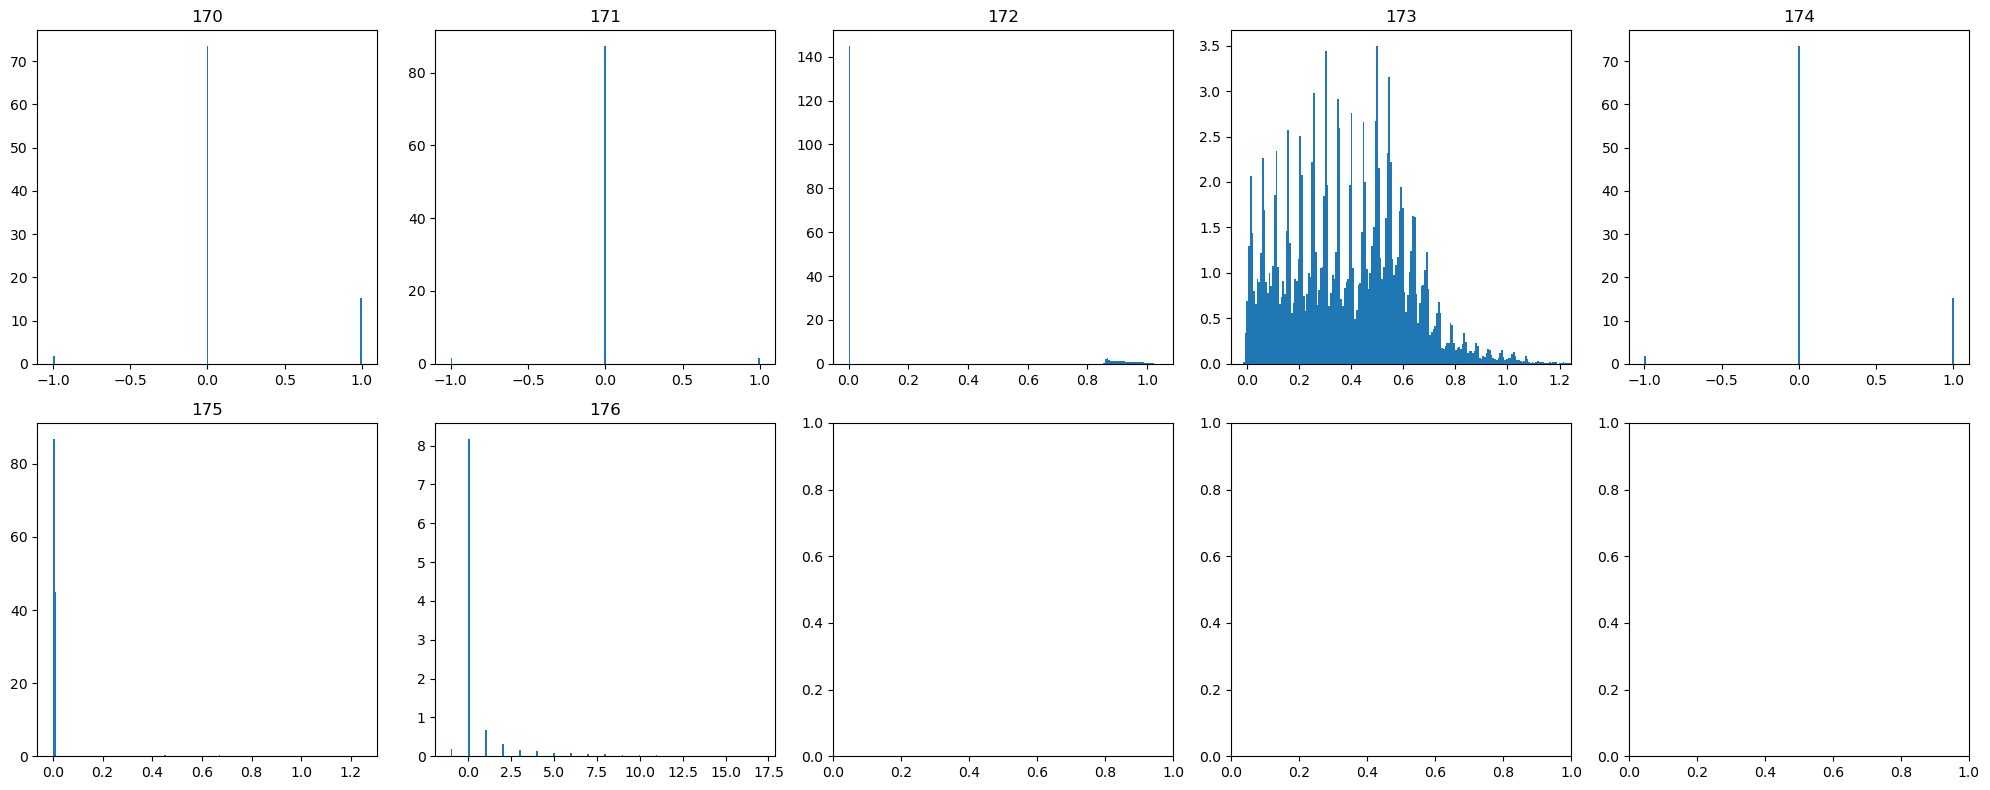

In [55]:
def plot_var(ax, xs):
    # remove missing values and outliers
    xs = xs[xs != -64]
    lower, upper = np.quantile(xs, 0.0025), np.quantile(xs, 1-0.0025)
    bins = np.linspace(lower - (upper - lower) * 0.05, upper + (upper - lower) * 0.05, 200)
    ax.hist(xs, bins=bins, density=True)
    ax.set_xlim([lower - (upper - lower) * 0.05, upper + (upper - lower) * 0.05])

NROWS = 2
NCOLS = 5
OFFSET = 17
TIMESTEP = 0
    
fig, axs = plt.subplots(ncols=NCOLS, nrows=NROWS, figsize=(20, 8))
for idx in range(OFFSET * NROWS * NCOLS, (1 + OFFSET) * NROWS * NCOLS):
    if idx >= 177: break
    i, j = idx // NCOLS - OFFSET * NROWS, idx % NCOLS
    plot_var(axs[i, j], X_train[:, TIMESTEP, idx])
    axs[i, j].set_title(idx)
fig.tight_layout()
plt.show()

## Analysing the classes

Raw text:

```
Skewed normal (with outlier):
(26), 39, 57, 68, (123, 125, 130, 137), (145), 153

Left and right half:
17, 19, 24, 46, 47, 52, 53

Left-half of normal distribution:
2, 7, 8, 9, 11, 29, 36, 40, 43, 44, 48, 50, 64, 67, 70, 71, 72, 76, 91, 127, 135, 136, 159

Left-half of of skewed normal distribution:
1, 20,  22, 30, 31, 38, 75, 104, 144, 147, 148, 149, 162

Right-half of normal distribution:

Right-half of of skewed normal distribution:
0, 150

One extreme value:
6, 13, 14, 18, 33, 34, 41, 51, 58, 60, 61, 69, 73, 74, 77, 80, 81, 82, 87, 89, 90, 92, 94, 95, 96, 98, 99, 102, 107, 108, 109, 110, 111, 113, 114, 118, 119, 120, (124, 126), 134, 138, 141, 158, 161, 163, 166, 167, 168, 169, 172, 175

Multiple spikes and normal mode:
3, 10, 23, 25, 37, 45, 49, 59, 63, 65, 66, 78, 79, 83, 93, 116, 133, 146, 151, 152, 176

Multiple spikes/modes:
4, 21, 32, 54, 55, 56, 62, 84, 85, 88, 97, 100, 112, 117, 122, 129, 132, (140), 143, 154, 155, 156, 157, 160, 170, 171, 174

Multiple modes skewed normal:
12, 131, 165, 173

Multiple modes normal:
16, 28

Other:
5, 15, 27, 35, 42, 86, 101, 103, 105, 106, 115, 121, 128, 139, 142, 164
```

In [168]:
# skewed normal, possibly with outliers
group1 = [26, 39, 57, 68, 123, 125, 130, 137, 145, 153]
# left and right tops
group2 = [17, 19, 24, 46, 47, 52, 53]
# left-half declining continous Poisson
group3 = [2, 7, 8, 9, 11, 29, 36, 40, 43, 44, 48, 50, 64, 67, 70, 71, 72, 76, 91, 127, 135, 136, 159]
# left-half like above, but with more mass in middle
group4 = [1, 20,  22, 30, 31, 38, 75, 104, 144, 147, 148, 149, 162]
# right-half of skewed normal, like above, but right-side
group5 = [0, 150]
# one extreme value (high density spike)
group6 = [6, 13, 14, 18, 33, 34, 41, 51, 58, 60, 61, 69, 73, 74, 77, 80, 81, 82, 87, 89, 90, 92, 94, 95, 96, 98, 99, 102, 107, 108, 109, 110, 111, 113, 114, 118, 119, 120, 124, 126, 134, 138, 141, 158, 161, 163, 166, 167, 168, 169, 172, 175]
# discrete-like normal with few spikes
group7 = [3, 10, 23, 25, 37, 45, 49, 59, 63, 65, 66, 78, 79, 83, 93, 116, 133, 146, 151, 152, 176]
# multiple spikes/modes
group8 = [4, 21, 32, 54, 55, 56, 62, 84, 85, 88, 97, 100, 112, 117, 122, 129, 132, 140, 143, 154, 155, 156, 157, 160, 170, 171, 174]
# Multiple modes/spikes, but looks skewed Gaussian overall
group9 = [12, 131, 165, 173]
# multiple modes, but looks normal  overall
group10 = [16, 28]
# Other
group11 = [5, 15, 27, 35, 42, 86, 101, 103, 105, 106, 115, 121, 128, 139, 142, 164]

groups = [group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11]
COLS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68', 'D_63', 'D_64', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']

# sanity check that all numeric values is included
all_ell = [j for sub in groups for j in sub]
assert len(all_ell), len(list(set(all_ell))) == (177, 177) and "No dupes"
assert list(sorted(all_ell)) == list(range(177)) and "All elements included"


for i, g in enumerate(groups):
    print(f"Group {i+1}: {list(sorted([COLS[j+11] for j in g]))}")

Group 1: ['D_104', 'D_124', 'D_52', 'D_56', 'D_73', 'R_27', 'S_12', 'S_22', 'S_24', 'S_27']
Group 2: ['B_16', 'B_17', 'B_6', 'B_9', 'D_48', 'D_60', 'D_61']
Group 3: ['B_1', 'B_12', 'B_13', 'B_14', 'B_15', 'B_23', 'B_25', 'B_28', 'B_3', 'B_37', 'B_4', 'B_42', 'D_42', 'D_43', 'D_53', 'D_62', 'D_71', 'D_74', 'D_75', 'D_76', 'R_26', 'S_26', 'S_9']
Group 4: ['B_11', 'B_40', 'B_7', 'D_115', 'D_118', 'D_119', 'D_132', 'D_39', 'D_50', 'D_55', 'D_77', 'D_88', 'S_5']
Group 5: ['D_121', 'P_2']
Group 6: ['B_21', 'B_24', 'B_26', 'B_29', 'B_32', 'B_36', 'B_41', 'B_5', 'D_108', 'D_111', 'D_131', 'D_133', 'D_135', 'D_136', 'D_137', 'D_138', 'D_141', 'D_144', 'D_41', 'D_49', 'D_54', 'D_65', 'D_69', 'D_81', 'D_84', 'D_89', 'D_93', 'D_94', 'P_4', 'R_12', 'R_13', 'R_14', 'R_15', 'R_17', 'R_19', 'R_2', 'R_20', 'R_21', 'R_22', 'R_24', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'S_16', 'S_17', 'S_18', 'S_20', 'S_23', 'S_25']
Group 7: ['B_2', 'D_107', 'D_113', 'D_122', 'D_123', 'D_145', 'D_44', 'D_51', 'D_59',

### Group 2: Left and right peaks

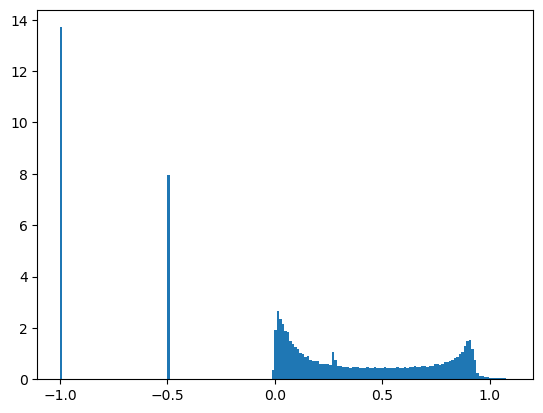

In [113]:
fig, ax = plt.subplots()
plot_var(ax, X_train[:, 0, group2[4]])

0.9150390262243601


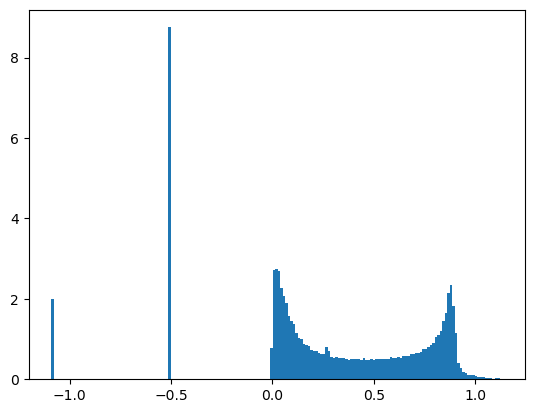

In [135]:
from scipy.stats import boxcox

res = boxcox(X_train[:, 10, group2[4]] - np.min(X_train[:, 0, group2[4]]) + 0.001)
fig, ax = plt.subplots()
plot_var(ax, res[0])
print(res[1])

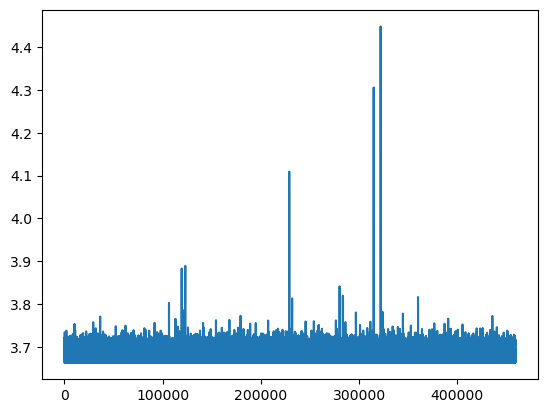

In [136]:
plt.plot(np.log(X_train[:, 10, group2[4]] + 40))

Possible preprocessing step is box-cox optimizer, followed by min-max into $[0, 1]$. The fit should learn the $\lambda$, then the transform should find a new minimum, but use the same $\lambda$.

### Group 6: Extreme values



Most of these seem close to categorical, so min-max into [0, 1] probably works best.

### Group 1: Skewed normal

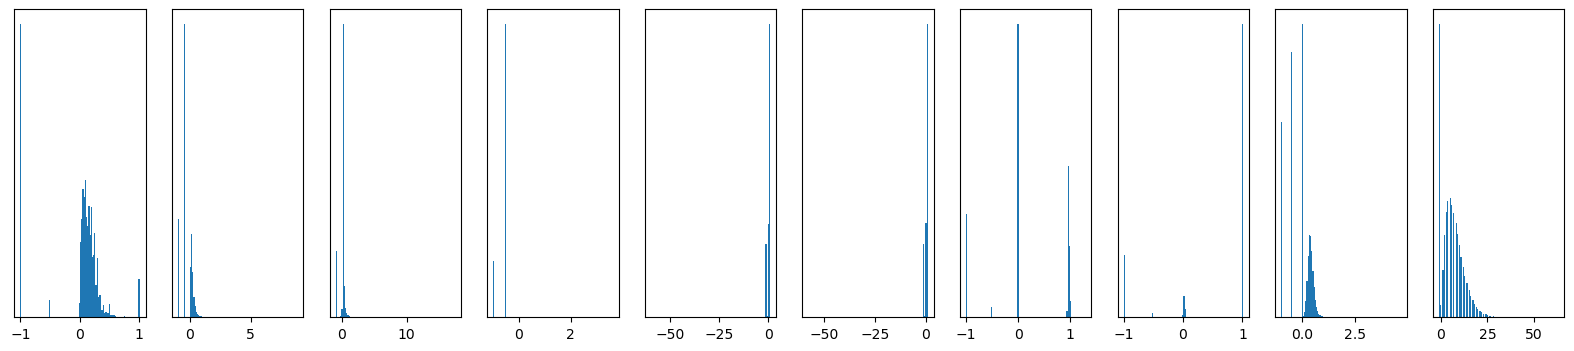

In [124]:
def plot_group(group):
    fig, axs = plt.subplots(ncols=min(10, len(group)), figsize=(20, 4))
    for i in range(min(10, len(group))):
        xs = X_train[:, 0, group[i]]
        xs = xs[xs > -60]
        axs[i].hist(xs, bins=100, density=True)
        axs[i].set_yticks([])
plot_group(group1)

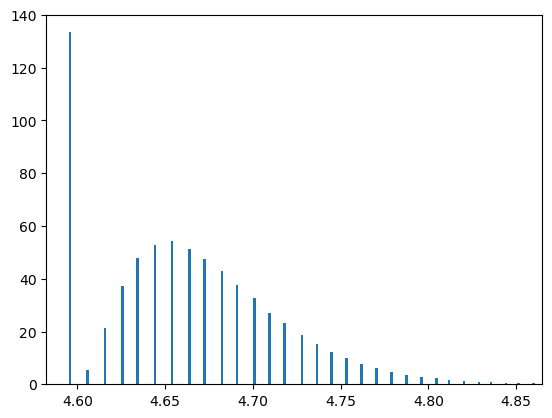

In [142]:
# try box-cox
# res = boxcox(X_train[:, 0, group1[4]] / 50 - np.min(X_train[:, 0, group1[4]]) / 50 + 1)
# print(res[1])
fig, ax = plt.subplots()
plot_var(ax, np.log(100 + X_train[:, 0, group1[9]] + 0.001))

In [115]:
nans = (X_train == -64) | (X_train == -1) | (X_train == -0.5)
nans.shape

(458913, 13, 177)

In [116]:
nans = nans.reshape((nans.shape[0], -1))
nans.shape

(458913, 2301)

In [143]:
np.mean(np.any(nans, axis=1))

1.0

For this group, applying log then standard scaling probably works best!

### Group 3

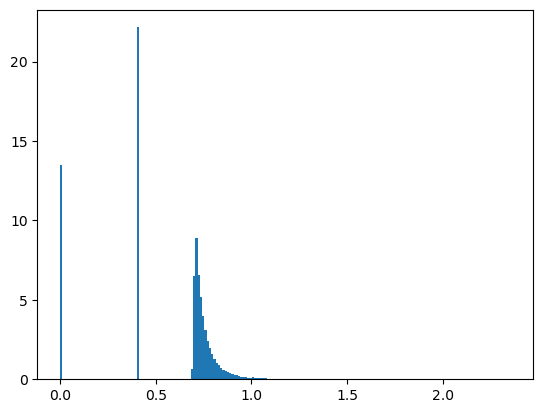

In [167]:
fig, ax = plt.subplots()
ax.hist(np.log(X_train[:, 0, group3[3]] + 2), bins=200, density=True)
plt.show()

Log-transform followed by standard scaling probably works best here.

### Group 4

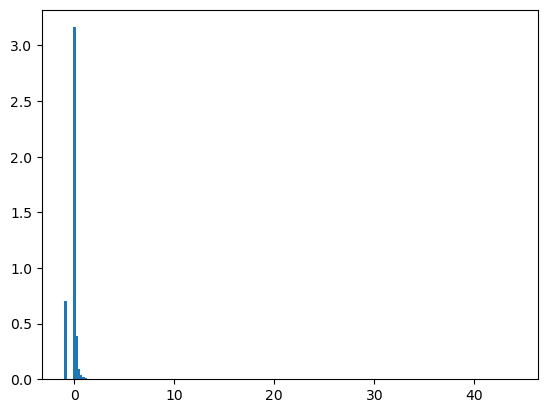

In [172]:
fig, ax = plt.subplots()
ax.hist(X_train[:, 0, group4[3]], bins=200, density=True)
plt.show()

Not really sure what works best here...

### Group 7

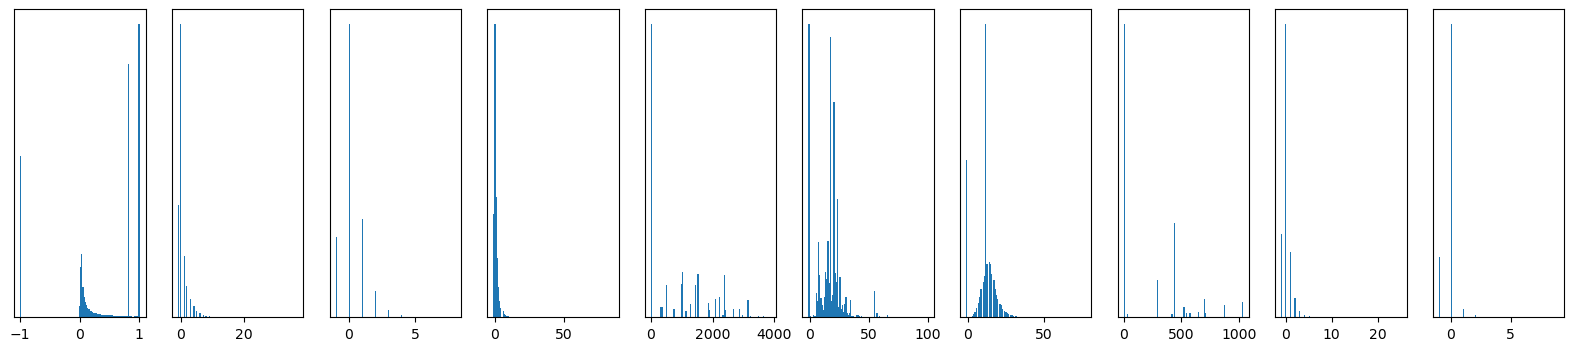

In [173]:
plot_group(group7)

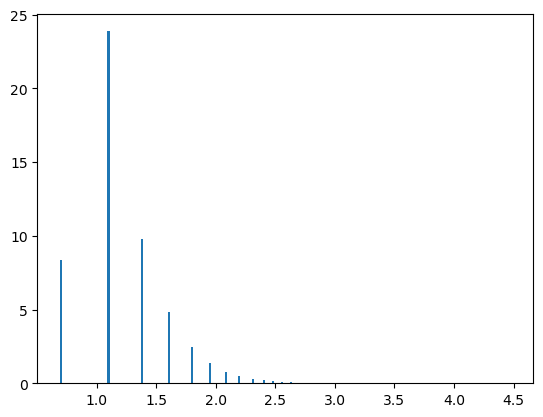

In [177]:
fig, ax = plt.subplots()
ax.hist(np.log(X_train[:, 0, group7[3]] + 3), bins=200, density=True)
plt.show()

Idk, a log transformation maybe?

### Group 8

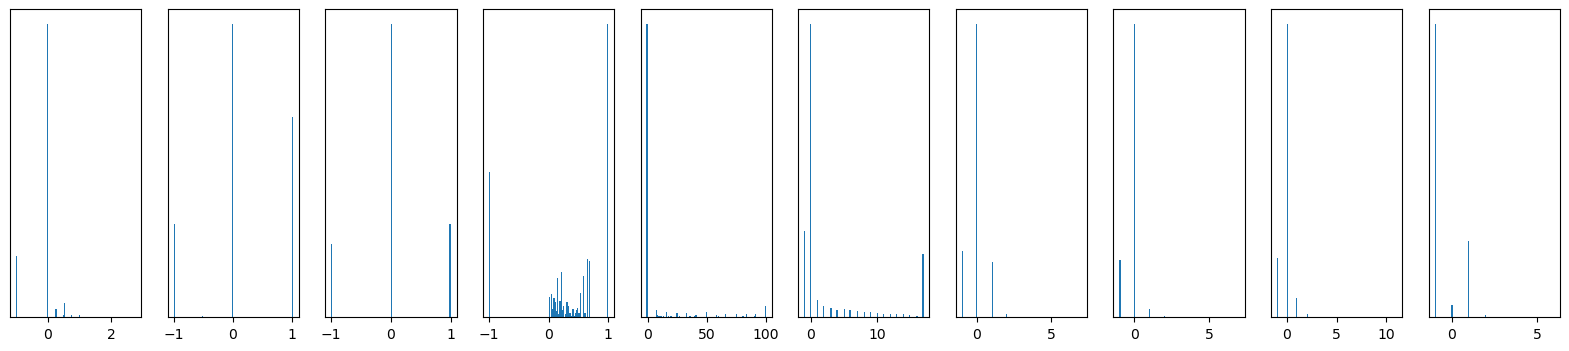

In [178]:
plot_group(group8)

Min-Max probably works best here...

### Group 9 and 10

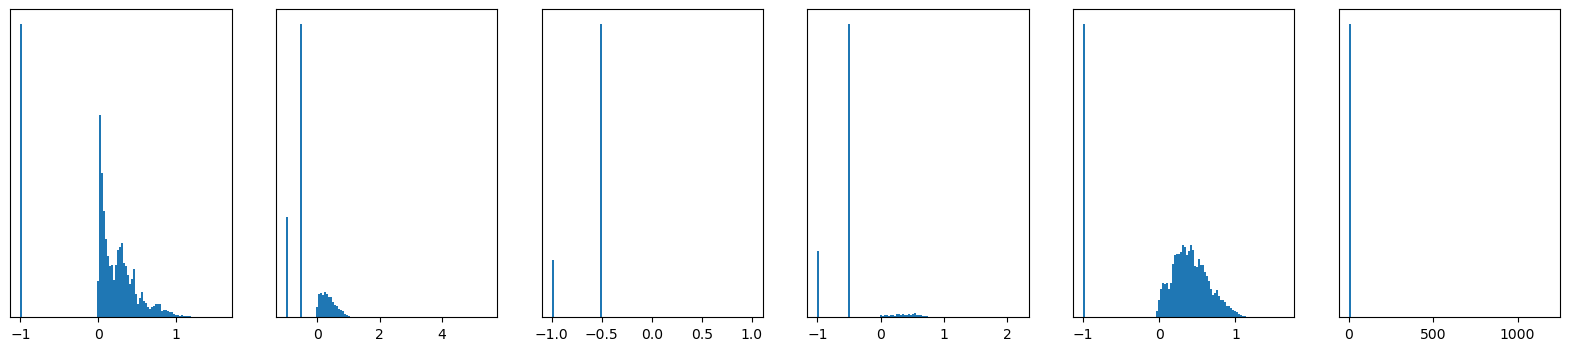

In [180]:
plot_group(group9 + group10)

### Group 11

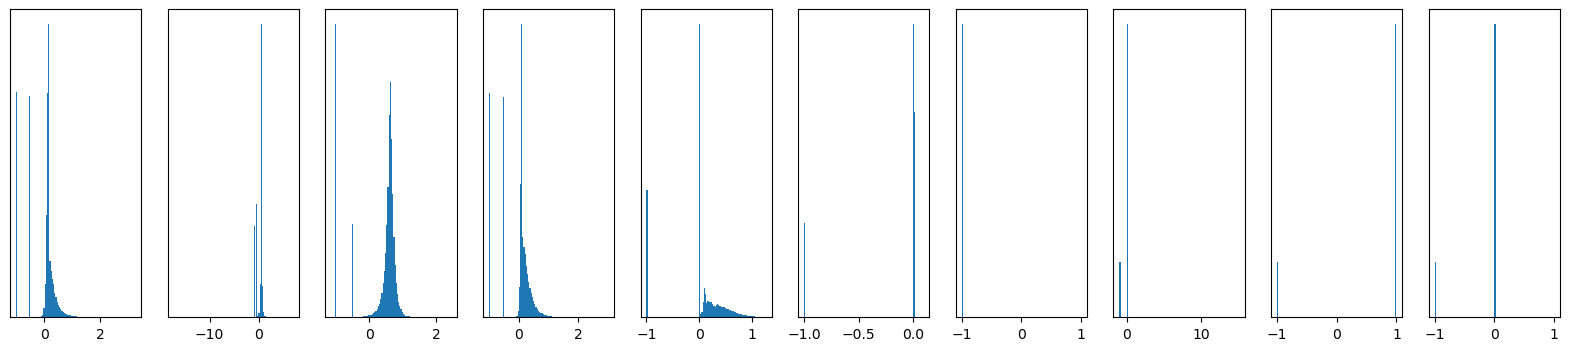

In [181]:
plot_group(group11)

## Clustering the variables automatically

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import yaml
import scipy
from tqdm.auto import tqdm
from src.lib.experimentation import load_amex_numpy_data, undo_min_max_corrupt_func
from src.preprocessing.static_transformations import MinMaxTimeSeries

with open(os.path.join("../config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    
fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -64,
    'pad_numeric' : -1,
}

In [3]:
X, y = load_amex_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    fill_dict,
    undo_min_max_corrupt_func
)
X.shape, y.shape

((458913, 13, 188), (458913,))

In [4]:
scaler = MinMaxTimeSeries(time_series_length=13)
X_scaled = scaler.fit_transform(X, y)
X_scaled.shape

(458913, 13, 188)

All the statistics should map $(N, T, D) \rightarrow (D,)$

In [5]:
def get_histogram(X, num_bins=1000):
    # Maps (N, T, D) array to (D, num_bins)
    # TODO: parallelize this with:
    #       https://stackoverflow.com/questions/66805185/parallel-python-for-loop-iterating-over-list-of-function-arguments
    #       using concurrent.features.ProcessPoolExeuctor
    
    D = X.shape[2]
    a = X.reshape((-1, D))
    hist = np.zeros((D, num_bins))
    # so that we get num_bins values when applying histogram
    bins = np.linspace(0, 1, num_bins + 1)
    
    for d in tqdm(range(D), desc="Binning data along each dimension"):
        hist[d, :] = np.histogram(a[:, d], bins)[0]
    return hist 

def get_distribution_statistics(X, y=None, T=13, num_bins=1000):
    """
    Takes input array of shape (N, T, D) and returns an array of shape (D, L),
    where L is the number of statistics computed by this function. Currently, L = 6
    """
    scaler = MinMaxTimeSeries(time_series_length=T)
    D = X.shape[2]
    X_scaled = scaler.fit_transform(X, y)
    
    # bin all the data, required for certain statistics
    hist = get_histogram(X_scaled, num_bins) # (D, num_bins)
    # merge num_samples and time-axis, required for certain statistics
    X_flat = X_scaled.reshape((-1, D))       # (N', D)
    # collect all the statistics of shape (D,) here
    X_statistics = []
    
    # Statistic 1: skewness
    X_statistics.append(
        scipy.stats.skew(X_flat, axis=0, nan_policy='raise')
    )
    # Statistic 2: kurtosis
    X_statistics.append(
        scipy.stats.kurtosis(X_flat, axis=0, nan_policy='raise')
    )
    # Statistic 3: std
    X_statistics.append(
        np.std(X_flat, axis=0)
    )
    # Statistic 4: normalized location of highest mode
    X_statistics.append(
        np.argmax(hist, axis=1) / num_bins
    )
    # Statistic 5: normalized number of unique values
    X_statistics.append(
        np.apply_along_axis(lambda x : np.sum(x > 0), axis=1, arr=hist) / num_bins
    )
    # Statistic 6: number of values in highest frequent bin
    X_statistics.append(
        np.max(hist, axis=1)
    )
    
    return np.stack(X_statistics, axis=1)

In [57]:
from scipy.stats import entropy
from sklearn.cluster import AgglomerativeClustering

# clustering using KL-divergence
def cluster_variables_with_kl_difference(X, k, y=None, num_bins=1000):
    """
    Given an array of shape (N, T, D), returns a list of lists
    of k lists, constituting a partition of the {1, ..., D} variables
    """
    D = X.shape[2]
    T = X.shape[1]
    
    scaler = MinMaxTimeSeries(time_series_length=T)
    X_scaled = scaler.fit_transform(X, y)
    
    hist = get_histogram(X_scaled, num_bins) # (D, num_bins)
    
    W = np.zeros((D, D))
    # calculate pair-wise mutual information estimates
    for i in range(D):
        for j in range(i + 1, D):
            # apply plus-1 smoothing to avoid divisions by zero
            W[j, i] = entropy(hist[i] + 1, hist[j] + 1)
    # make the matrix symmetric
    # return W
    W = np.tril(W) + np.triu(W.T, 1)
    
    ac = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="average")
    ac.fit(W)

    groups = []
    for i in range(k):
        groups.append(list(np.arange(D)[ac.labels_ == i]))
    return groups

In [61]:
groups = cluster_variables_with_kl_difference(X, 30)

Binning data along each dimension:   0%|          | 0/188 [00:00<?, ?it/s]

In [62]:
for i in range(len(groups)):
    print(f"group {i}:")
    print("\t" + ", ".join([str(_) for _ in groups[i]]))

group 0:
	63, 74, 90, 91, 108
group 1:
	69, 81, 82, 83, 84, 94, 107
group 2:
	25, 43, 44, 65, 101, 106, 111, 116, 118, 120, 122, 123, 125, 126, 129, 130, 131, 132, 133, 134, 136, 140, 145, 148, 150, 154, 166, 181, 182, 185
group 3:
	29, 39, 62, 72, 88, 92, 99, 105, 112, 127, 128, 143, 147, 149, 152, 155, 162, 164, 177, 178, 179, 180, 183, 184, 186, 187
group 4:
	11, 13, 14, 18, 23, 26, 27, 31, 37, 38, 42, 53, 57, 64, 78, 117, 137, 139, 146, 153, 158, 159, 160, 161, 172, 174, 176
group 5:
	73, 77
group 6:
	79, 170
group 7:
	15, 16, 17, 19, 20, 28, 40, 46, 49, 50, 54, 55, 56, 59, 60, 61, 86, 87, 142, 156, 173
group 8:
	76, 89, 95
group 9:
	12, 21, 22, 24, 30, 33, 35, 36, 41, 47, 51, 58, 68, 71, 75, 85, 93, 102, 138
group 10:
	97, 141
group 11:
	1, 4
group 12:
	135
group 13:
	34, 96, 98, 114, 165
group 14:
	48, 70, 100
group 15:
	32, 167, 171
group 16:
	115
group 17:
	8, 10
group 18:
	52, 104, 121, 157
group 19:
	0, 2, 3, 5, 6, 7
group 20:
	151
group 21:
	119
group 22:
	67, 103, 169
group

array([6, 3, 6, 6, 3, 6, 6, 6, 0, 3, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1,
       0, 7, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 4, 0, 4, 0,
       0, 0, 0, 0, 2, 0, 0, 8, 5, 2, 5, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 5, 0, 8, 2, 0, 0, 8, 0, 0, 8, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2,
       7, 1, 2, 0, 0, 2, 0, 1, 1, 4, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 0, 2, 0, 0, 1, 3, 2, 2, 0, 2, 2, 2, 0, 2, 1, 4, 2, 4,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 0, 5, 2, 0, 3, 0, 4, 7,
       4, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1])

In [125]:
dist_stats = get_distribution_statistics(X)
dist_stats.shape

Binning data along each dimension:   0%|          | 0/188 [00:00<?, ?it/s]

(188, 6)

In [143]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dist_stats_scaled = scaler.fit_transform(dist_stats)

km = KMeans(n_clusters=11, random_state=42, n_init='auto')

km = km.fit(dist_stats_scaled)
labs = km.labels_
labs

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  8,  0,  8,  6,  8,  0,
        0,  8,  0,  0,  7,  0,  8,  0,  1,  8,  8,  7,  4,  2,  8,  9,  6,
        4,  0,  0,  8,  8, 10,  0,  0,  6,  9,  5,  1,  8, 10,  9,  0,  0,
        7,  7,  8,  0,  0,  0,  8,  7,  0,  0,  7,  2,  9,  6,  5,  9,  9,
        0,  0,  9,  0,  2,  4,  7,  0,  4,  7,  6,  0,  6,  7,  7,  7,  0,
        0,  7,  8,  2,  7,  7,  7,  4,  0,  7,  7,  7,  6,  4,  4,  8,  5,
        0,  7,  7,  2,  1,  7,  7,  0,  1,  1,  4,  7,  7,  0,  5,  6,  1,
        1,  1,  7,  1,  5,  4,  1,  1,  4,  1,  1,  1,  1,  1,  1,  5,  6,
        5,  8,  0,  8,  9,  9,  0,  2,  7,  6,  8,  4,  5,  4,  1,  4,  4,
        0,  5,  3,  8,  7,  8,  8,  8,  8,  7,  7,  7,  7,  1,  9,  9,  7,
        7,  9,  9,  0,  8,  1,  4,  4,  4,  4,  4,  1,  1,  9,  8,  1,  8,
        4], dtype=int32)

In [139]:
np.arange(188)[labs == 1]

array([  0,   5,   6,   7,  47,  73,  99, 128, 154, 166, 181, 185, 187])

In [144]:
for i in range(11):
    print(f"Cluster {i} contains")
    print("\t" + ", ".join([str(_) for _ in np.arange(188)[labs == i]]))

Cluster 0 contains
	12, 16, 17, 19, 20, 22, 24, 35, 36, 40, 41, 49, 50, 54, 55, 56, 59, 60, 68, 69, 71, 75, 79, 84, 85, 93, 102, 109, 115, 138, 142, 153, 173
Cluster 1 contains
	25, 45, 106, 110, 111, 118, 119, 120, 122, 125, 126, 128, 129, 130, 131, 132, 133, 150, 166, 175, 181, 182, 185
Cluster 2 contains
	30, 62, 72, 88, 105, 143
Cluster 3 contains
	155
Cluster 4 contains
	29, 34, 73, 76, 92, 98, 99, 112, 124, 127, 147, 149, 151, 152, 176, 177, 178, 179, 180, 187
Cluster 5 contains
	0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 44, 65, 101, 116, 123, 134, 136, 148, 154
Cluster 6 contains
	14, 33, 42, 64, 78, 80, 97, 117, 135, 145
Cluster 7 contains
	21, 28, 51, 52, 58, 61, 74, 77, 81, 82, 83, 86, 89, 90, 91, 94, 95, 96, 103, 104, 107, 108, 113, 114, 121, 144, 157, 162, 163, 164, 165, 169, 170
Cluster 8 contains
	11, 13, 15, 18, 23, 26, 27, 31, 37, 38, 46, 53, 57, 87, 100, 137, 139, 146, 156, 158, 159, 160, 161, 174, 184, 186
Cluster 9 contains
	32, 43, 48, 63, 66, 67, 70, 140, 141, 167, 168, 17

In [ ]:
sklearn.cluster

In [66]:
hist = get_histogram(X_scaled[:, :, :])

Binning data along each dimension:   0%|          | 0/188 [00:00<?, ?it/s]

In [123]:
temp = [np.ones((100)) for _ in range(7)]
np.stack(temp, axis=1).shape

(100, 7)

In [113]:
np.argmax(hist, axis=0)

array([112,  88,  47,  85,  85,  12,  93,  24,  24,  66,  36, 138,  71,
        71,  75,  82,  81,  41, 187, 135,  52,  21,  21,  75,  68, 104,
        59, 104, 104,  52,  83,  83, 107,  94, 107, 107,  35,  74,  74,
        74, 103,  50,  61, 113,  86, 113, 109, 144,  59, 170, 170,  59,
        91, 109,  35,  67,  40, 157, 169, 109,  35,  84,  91, 109,  69,
        69, 165, 109,  59,  55,  55, 173, 173,  40,  40, 142,  63, 142,
        40, 156, 173,  16,  59,  96,  61,  61,  61,  61, 156,  61, 114,
        59,  86,  61,  86, 144,  19,  55,  48, 124,  76,  28,  28,  79,
        28,  19,  46,  77,  79,  77,  28,  98,  28,  28,  87,  87,  28,
        17,  17,  74,  46,  79,  77,  17,  17,  73,  79,  77,  17,  17,
        54,  17,  20, 162,  20,  20, 115, 115,  55,  20,  77,  20, 127,
        20,  60,  77,  20,  40,  77, 144,  55,  17,  17,  63, 184, 184,
       184,  77, 164, 156,  60,  56, 115,  77,  60,  55, 127,  28,  60,
        87, 156,  87, 156,  60, 164,  77, 156, 156, 156, 161,  1

In [111]:
hist.shape

(188, 1000)

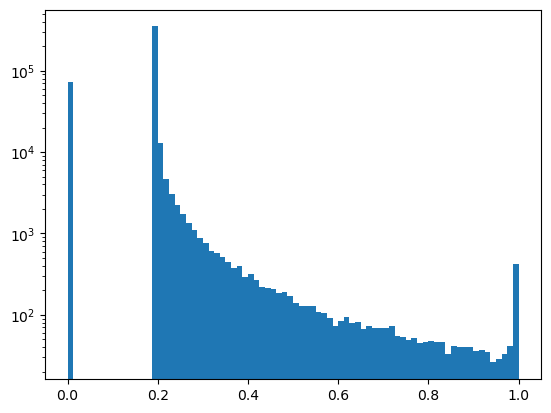

In [97]:
plt.hist(X_scaled[:, 0, 100], bins=80)
plt.yscale('log')
plt.show()